In [ ]:
# default_exp nbeats.metrics

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats metrics

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.model import *

## Metrics 

In [ ]:
# export
def _get_key_from_nested_dct(dct, s_key, exclude = [], namespace=''):
    r = {}
    for key in dct.keys():
        if sum([exc in key for exc in exclude])== 0 :
            if type(dct[key]) == dict:
                r.update(_get_key_from_nested_dct(dct[key], s_key, exclude, namespace=namespace+key))
            if s_key in key:
                r[namespace+key] = dct[key]
    return r

In [ ]:
dct = {'foo':{'bar':1},'bar':2,'foo2':{'foo3':3},'ignore':{'bar':1000}}
r = _get_key_from_nested_dct(dct,'bar',['ignore'])
test_eq(r,{'foobar': 1, 'bar': 2})

In [ ]:
#export
class NBeatsTheta(Metric):
    "The sqaure of the `theta` for every block. "
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)         
        theta_dct = _get_key_from_nested_dct(learn.n_beats_trainer.out,'theta',['bias','total','att'])
        t = torch.cat([v.float() for k,v in theta_dct.items()])
        self.total += to_detach(t.abs().mean())*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "theta"

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )

mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seaonality'), horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsTheta()],
                cbs=L(NBeatsTrainer())
               )

learn.fit(3,.1)
test_eq(type(learn.metrics[0].value),Tensor)

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,theta,time
0,9.483101,29.125875,0.309634,00:00
1,6.771714,10.524466,0.258932,00:00
2,4.820271,1.625215,0.140535,00:00


In [ ]:
#export
class NBeatsBackwards(Metric):
    "The loss according to the `loss_func` on the backwards part of the time-serie."
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)   
        b = learn.n_beats_trainer.out['total_b']
        value = learn.loss_func(b.float(), *learn.xb, reduction='mean')
        self.total += to_detach(value)*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return "b_loss"

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )

mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seaonality'), horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, metrics=[NBeatsBackwards()],
                cbs=L(NBeatsTrainer())
               )

learn.fit(3,.1)
test_eq(type(learn.metrics[0].value), Tensor)

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,b_loss,time
0,8.142207,15.177962,5.737937,00:00
1,5.951160,10.393651,6.248781,00:00
2,4.511688,0.583673,3.075855,00:00


## Callbacks

In [ ]:
# export
class NBeatsAttention(Callback):    
    def att(self,df=True):
        dct = {}        
        for k,v in learn.n_beats_trainer.out.items():
            if isinstance(k,str):
                if 'seaonality' in k or 'trend' in k:
                    dct[k]={'att_mean':v['attention'].mean().cpu().numpy(),
                            'att_std':v['attention'].std().cpu().numpy()}
        if df:
            return pd.DataFrame(dct)
        return dct

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )
stack_types = ('trend','seaonality')
mdl = NBeatsNet(device = data.train.device, stack_types=stack_types, nb_blocks_per_stack = 1, horizon=horizon, lookback=lookback)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, 
                cbs=L(NBeatsTrainer(),NBeatsAttention()
                     )
               )

learn.fit(3,.1)
df = learn.n_beats_attention.att()
df

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,time
0,7.643333,12.760280,00:00
1,7.018129,0.826835,00:00
2,5.923955,0.319152,00:00


,trend0_0,seaonality1_0
att_mean,1.0,1.0
att_std,0.0,0.0


In [ ]:
# hide
test_eq(list(df.columns),[o+str(i)+'_0' for i,o in enumerate(stack_types)])
test_eq(1>=df.loc['att_mean','trend0_0']>=0, True)

In [ ]:
# export
class NBeatsTheta(Callback):  
    def means(self, df=True):
        theta_means = {k.replace('theta',''):v.float().cpu().data for k,v in _get_key_from_nested_dct(learn.n_beats_trainer.out,'theta',['total']).items()}
        ret = {}
        for k,v in theta_means.items():
            ret[k] = {}
            for i in range(v.shape[-1]):
                ret[k].update({'theta_'+str(i)+'_mean': v[:,i].mean().numpy(),
                               'theta_'+str(i)+'_std': v[:,i].std().numpy(),
                              })
            
#         ret = {k+'_theta_'+str(i):v }
        att = {k.replace('attention','att_mean'):v.mean().float().cpu().numpy() for k,v in _get_key_from_nested_dct(learn.n_beats_trainer.out,'att',['total']).items()}
        for k in ret.keys():
            for att_key in att.keys():
                if k in att_key:
                    ret[k].update({'att_mean':att[att_key]})
                
        if df:
            return pd.DataFrame(ret)
        return ret

In [ ]:
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=1, after_batch = NormalizeTS()
                               )
stack_types = ('trend','seaonality')
thetas_dim= (4,2)
mdl = NBeatsNet(device = data.train.device, stack_types=stack_types, nb_blocks_per_stack = 1, horizon=horizon, lookback=lookback, thetas_dim=thetas_dim)
loss_func = F.mse_loss
learn = Learner(data, mdl, loss_func=loss_func, opt_func= Adam, 
                cbs=L(NBeatsTrainer(),NBeatsTheta()
                     )
               )

learn.fit(3,.1)
df = learn.n_beats_theta.means()
df

Train:89; Valid: 33; Test 3


epoch,train_loss,valid_loss,time
0,14.895495,145.378387,00:00
1,23.739845,21.062042,00:00
2,17.533102,129.050461,00:00


,trend0_0,seaonality1_0
theta_0_mean,-0.09999997,-1.0
theta_0_std,0.0,0.0
theta_1_mean,-0.09999997,1.0
theta_1_std,0.0,0.0
theta_2_mean,-0.09999997,NaN
theta_2_std,0.0,NaN
theta_3_mean,-0.09913775,NaN
theta_3_std,4.636702e-08,NaN
att_mean,1.0,1.0


In [ ]:

class NBeatsTrainer(Callback):
    "`Callback` that adds weights regularization the thetas in N-Beats training."
    def __init__(self, theta=0., b_loss=0.): 
        self.theta, self.b_loss = theta, b_loss
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        self.b = None

    def begin_train(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def begin_validate(self): 
        self.out = defaultdict(dict)
        self.metrics = {'theta':tensor([0.]), 'b_loss':tensor([0.])}
        
    def after_pred(self):
        self.b = self.pred[1] 
        self.pred[2]['total_b'] = self.pred[1] 
        self.out = concat_dct(self.pred[2], self.out)   
        self.learn.pred = self.pred[0]

    def after_loss(self):        
        # theta
        value=tensor([0.])
        for key in self.out.keys():
            if 'bias' not in key and 'total' not in key and 'att' not in key:
                v = self.out[key]['theta'].float().pow(2).mean()
                if self.theta != 0.:     
                    self.learn.loss += self.theta * v.item()
                value = value + v
        self.metrics['theta'] += value.clone().cpu().detach()
        
        # backwards 
        value = self.learn.loss_func(self.b.float(), *self.xb, reduction='mean') 
        if self.b_loss != 0.:
            self.learn.loss += self.b_loss * value.mean() 
        self.metrics['b_loss'] += value.sum().clone().detach()
            


In [ ]:

def CombinedLoss(*losses, ratio:dict=None):
    _ratio = defaultdict(lambda:1.)
    if ratio is not None:
        _ratio.update(ratio)    
    ratio = _ratio
    
    def _inner(pred, truth, *args,**kwargs):
        loss = None
        for _loss in losses:
            if loss is None:
                loss = ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
            else:
                loss += ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs)
        return loss
    
    return _inner
#     metrics = L()
#     for _loss in losses:
#         metrics.append(lambda pred, truth, *args,**kwargs: ratio[_loss.__name__] * _loss(pred, truth, *args,**kwargs))
#     print(metrics)
  

In [ ]:
y, y_hat = torch.arange(10).float(), torch.arange(10).float()+torch.randn(10)
loss_fnc = CombinedLoss(F.mse_loss,smape)
test_eq(F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))

r = 10
loss_fnc = CombinedLoss(F.mse_loss, smape, ratio = {'mse_loss':r})
test_eq(r*F.mse_loss(y,y_hat)+smape(y,y_hat),loss_fnc(y, y_hat))


## Learner

In [ ]:
# export
# from fastai2.basics import *
# from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataLoaders, output_channels=None, metrics=None,cbs=None, theta=0., b_loss=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"    
    model = NBeatsNet(
        device = dbunch.train.device,
        horizon = dbunch.train.horizon,
        lookback = dbunch.train.lookback, 
        **kwargs
       )
    
    loss_func = ifnone(loss_func, CombinedLoss(F.mse_loss, smape, ratio = {'smape':.0005}))
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, 
                    metrics=L(metrics)+L(mae, smape, F.mse_loss, NBeatsTheta(), NBeatsBackwards()),
                    cbs=L(NBeatsTrainer(theta, b_loss))+L(cbs)
                   )
    learn.lh = (dbunch.train.lookback/dbunch.train.horizon)
    return learn

In [ ]:
# hide
from fastseq.data.external import *
items = dummy_data_generator(50, 10, nrows=100)
data = TSDataLoaders.from_items(items, horizon = 7)
learn = nbeats_learner(data,layers=[10], theta = .1, b_loss=.3, stack_types=("seasonality","trend"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.1}),)

learn.fit(1,.001)

Train:500; Valid: 800; Test 100


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 135, in _worker_loop
    init_fn(worker_id)
  File "/home/tako/dev/fastai2/fastai2/data/load.py", line 17, in _wif
    set_seed(info.seed)
  File "/home/tako/dev/fastai2/fastai2/torch_core.py", line 123, in set_seed
    try: np.random.seed(s%(2**32-1))
TypeError: 'int' object is not callable


In [ ]:
# hide
learn.n_beats_trainer.theta_means()

,seasonality0_0,seasonality0_1,seasonality0_2,trend1_0,trend1_1,trend1_2
0,-0.110665,0.055990,0.076000,-0.006880,0.003721,0.005748
1,0.115849,0.004087,0.072887,0.002325,0.006381,0.004293
2,0.045265,-0.052080,0.020286,-0.000561,0.004114,-0.001551


In [ ]:
# hide
learn.n_beats_trainer.attention()

,seasonality0_0,seasonality0_1,seasonality0_2,trend1_0,trend1_1,trend1_2
mean,0.53,0.50,0.44,0.42,0.49,0.49
std,0.11,0.04,0.09,0.07,0.07,0.07


# Example

Train:10000; Valid: 2000; Test 1000


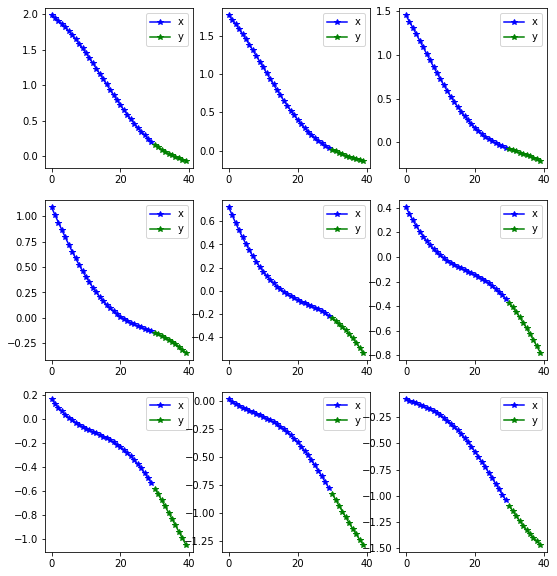

In [ ]:
from fastseq.all import *
from fastseq.data.external import *

items = dummy_data_generator(100, 10, nrows=1000)
data = TSDataLoaders.from_items(items, horizon = 10,lookback = 30, step=5,bs=256)
data.show_batch()

In [ ]:
learn = nbeats_learner(data,layers=[32,], stack_types=("seasonality","trend"), b_loss=.3,
                           loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.001}),)

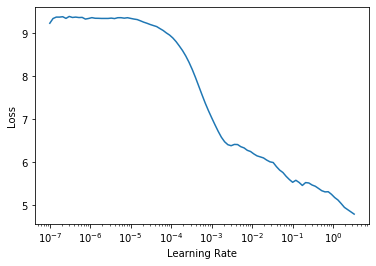

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,3.495418,9.015073,0.705015,0.984408,0.866673,0.443482,116.802689,00:04
1,4.145363,6.968073,0.342625,0.534867,0.222377,0.746687,99.115227,00:04
2,3.373105,2.606782,0.336716,0.548731,0.216128,1.022472,35.165604,00:04
3,2.786571,2.054426,0.325672,0.529629,0.202161,1.110515,27.373755,00:04
4,2.406258,3.400542,0.240242,0.428064,0.109550,1.285196,48.421837,00:04
5,2.198395,3.465778,0.185793,0.346397,0.067648,1.436717,49.846462,00:04
6,1.981110,3.098657,0.188971,0.349960,0.067086,1.527313,44.231625,00:04
7,1.797857,3.715926,0.152056,0.302812,0.044015,1.590400,53.718399,00:04
8,1.650044,3.597585,0.160190,0.316353,0.049891,1.627880,51.972023,00:04
9,1.585304,3.504094,0.159449,0.314174,0.049095,1.624851,50.553764,00:04


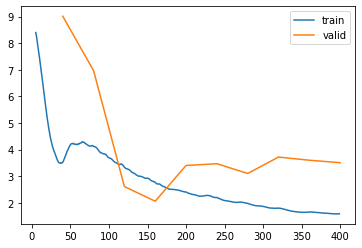

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

In [ ]:
learn.show_results(max_n=9)

TypeError: __init__() missing 2 required positional arguments: 'items' and 'horizon'

In [ ]:
learn.n_beats_trainer.attention()

,seasonality0_0,seasonality0_1,seasonality0_2,trend1_0,trend1_1,trend1_2
mean,0.68,0.59,0.51,0.49,0.50,0.54
std,0.16,0.16,0.10,0.02,0.02,0.08


## Second Example 

In [ ]:
learn = nbeats_learner(data,layers=[200,200,100], b_loss= .5, stack_types=('bias',"trend","seasonality"),
                       loss_func= CombinedLoss(F.mse_loss, smape, ratio = {'smape':.01}))

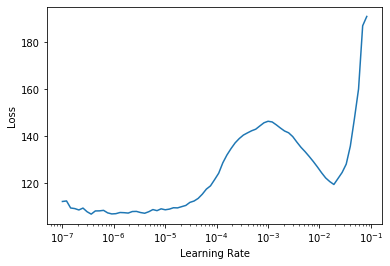

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

epoch,train_loss,valid_loss,mae,smape,mse_loss,theta,b_loss,time
0,158.310699,103.363380,0.627129,0.858792,0.653212,0.482799,901.058044,00:06
1,81.818092,7.619723,0.296132,0.503784,0.174640,1.031285,63.421970,00:06
2,44.108242,8.667117,0.240571,0.433564,0.116963,1.135933,75.371399,00:06
3,22.821661,31.409008,0.314136,0.488235,0.164115,2.612896,278.265503,00:06
4,15.476551,15.863174,0.349355,0.569416,0.201257,1.106476,139.716934,00:06
5,15.578620,30.764700,0.307523,0.513211,0.163140,1.608389,270.026337,00:06
6,11.905681,10.691910,0.225449,0.348643,0.146373,1.712264,91.923279,00:06
7,20.742487,34.769115,0.280031,0.437088,0.132432,1.662644,303.015808,00:06
8,18.536810,26.848816,0.229279,0.392989,0.095520,2.147459,233.752853,00:06
9,16.204859,27.254950,0.220036,0.382599,0.090000,2.217069,237.485992,00:06


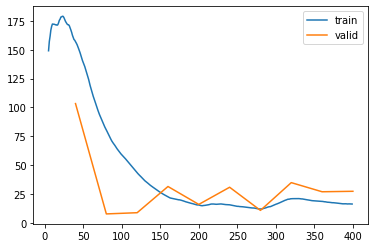

In [ ]:
learn.fit_one_cycle(10, 2e-3)
learn.recorder.plot_loss()

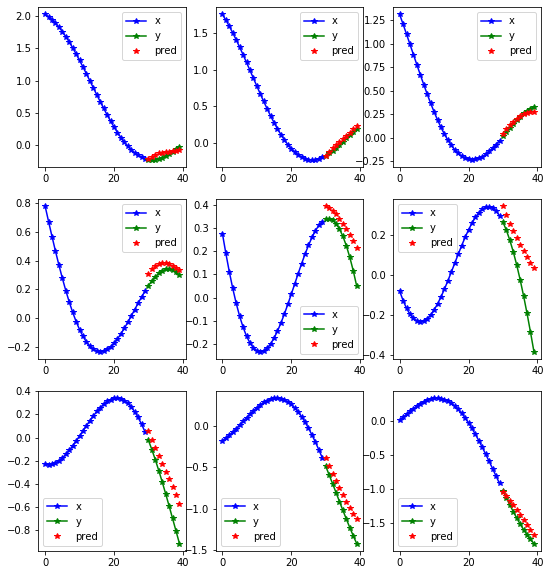

In [ ]:
learn.show_results(max_n=9)

In [ ]:
# hide
print(learn.summary())

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 07_interpret.ipynb.
Converted 10_metrics.ipynb.
Converted 11_nbeats.metrics.ipynb.
Converted index.ipynb.
